<a href="https://colab.research.google.com/github/Ikeda33/codespaces-railstutorial/blob/main/selfattention_50epoch_flower_D_sa_G_sa_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
#パッケージのダウンロード


In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import argparse

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim

In [43]:
import torchvision.transforms as transforms

In [44]:
import torchvision.datasets as dset

In [45]:
import torchvision.utils as vutils

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [47]:
import glob

In [48]:
from torch.utils.data import Dataset
from PIL import Image

In [49]:
from torch.utils.data import DataLoader
import torchvision

In [50]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


In [51]:
kid = KernelInceptionDistance(subset_size=15)

In [52]:
#ハイパーパラメータの設定

In [53]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=50)
parser.add_argument("--batch_size", type = int, default=32)
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=64)
parser.add_argument("--nch_d", type = int, default=64)
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(n_epoch=50, batch_size=32, lr_g=0.0002, lr_d=0.0003, nch_g=64, nch_d=64, z_dim=100, beta1=0.5)


In [54]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
        #self.file_list = glob.glob("/content/drive/MyDrive/Test/**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform


    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img

    def __len__(self):
        return len(self.file_list)

In [55]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([

    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

In [56]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [57]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [58]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [59]:
#モデルの設定

In [60]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [61]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [62]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),

        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),

    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [63]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [64]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [65]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [66]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        out_channels = in_channels // n_divide
      #  out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [67]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [68]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z)
        z = self.relu(z)

        z = self.conv2(z)
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2\n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels)\n        self.bn = n

In [69]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [70]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [71]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [72]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding\n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [73]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)

        self.flat = nn.Flatten()

        self.linear_1 = nn.Linear(32,64, bias=False)
        self.linear_2 = nn.Linear( 32,32, bias=False)#if ( 64,32, bias=False)  -> mat1 and mat2 shapes cannot be multiplied (131072x32 and 64x32)


    def shortcut(self, x):
        x = self.conv3(x)
        #x = self.se_block_1(x)
        x = self.bn(x)
        return x

    def forward(self, x):

        identity = x#入力
        x = self.pre_bn(x)
        x = self.se_block_0(x)
       # x = self.attention(x) - x
        x = x + identity


        identity = x#入力
        x = self.pre_bn(x)
       # b, c, h, w = x.size()
        x = self.conv1(x)


      #  x = self.linear_1(x).view(b, -1, h, w)
        x = self.relu(x)
       # x = self.linear_2(x).view(b, -1, h, w)


        x =  self.shortcut(identity) + x
        #x = x + self.shortcut(identity)
        x = self.bn(x)

        return x

In [74]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)

    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [75]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()

        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels

        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )


    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=True, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE_G(out_channels))
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))



        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.convt1(x)

        out = self.convt2(out)

        out = self.convt3(out)

        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [76]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf , attention = True)
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf, attention = True )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf, attention = True)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)


    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))


        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.conv1(x)

        out = self.conv2(out)

        out = self.conv3(out)

        out = self.conv4(out)

        out = self.conv5(out)

        return out

In [77]:
#モデルのトレーニング

In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [79]:
device

device(type='cuda')

In [80]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspose2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-2)
    )
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspo

In [81]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 103/103 [00:10<00:00, 10.13it/s]


epoch: 0, lossD:0.1018551814469319, lossG:11.110910823044268,lossG_fake:5.7674546264907685, lossG_real:5.343456216228819 ,equality:0.42399841026194984


evaluate:86.4122085571289,kid_mean:0.07634659856557846, kid_std:0.0466906912624836,kid_:(tensor(0.0763), tensor(0.0467))


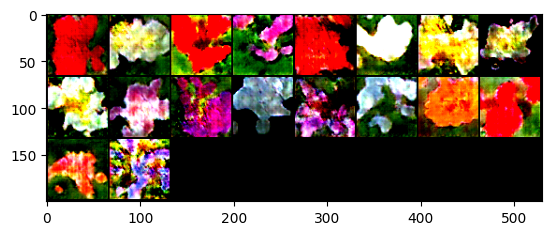

100%|██████████| 103/103 [00:09<00:00, 10.31it/s]


epoch: 1, lossD:0.17080861181744095, lossG:11.410935522283165,lossG_fake:6.149286443747363, lossG_real:5.261649095896378 ,equality:0.8876373478509851


evaluate:86.66329193115234,kid_mean:0.07494351267814636, kid_std:0.04514630138874054,kid_:(tensor(0.0749), tensor(0.0451))


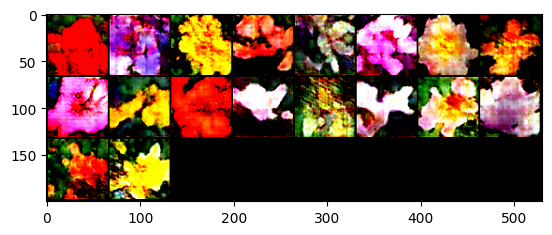

100%|██████████| 103/103 [00:09<00:00, 10.36it/s]


epoch: 2, lossD:0.30343083615948274, lossG:11.772945329980942,lossG_fake:6.331390473449114, lossG_real:5.441554893567724 ,equality:0.8898355798813906


evaluate:88.1125259399414,kid_mean:0.07942982017993927, kid_std:0.046124670654535294,kid_:(tensor(0.0794), tensor(0.0461))


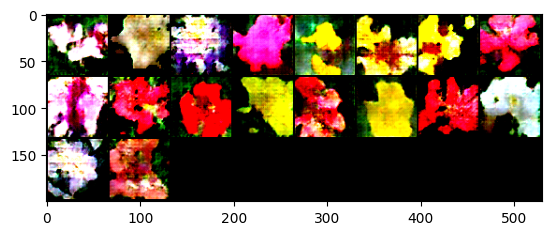

100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


epoch: 3, lossD:0.20338649062204708, lossG:11.174353886576531,lossG_fake:5.927428926079019, lossG_real:5.2469249894318075 ,equality:0.6805039366472112


evaluate:87.28288269042969,kid_mean:0.08006343990564346, kid_std:0.044163066893815994,kid_:(tensor(0.0801), tensor(0.0442))


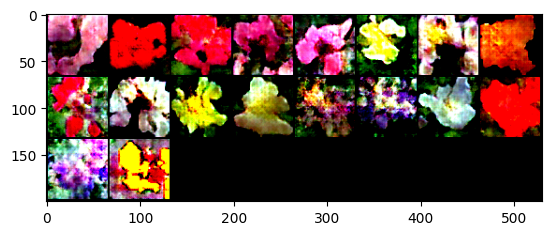

100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


epoch: 4, lossD:0.1843706157456324, lossG:11.591215966974648,lossG_fake:6.00435492135946, lossG_real:5.586861066447878 ,equality:0.41749385491158186


evaluate:86.75492095947266,kid_mean:0.08023979514837265, kid_std:0.047548238188028336,kid_:(tensor(0.0802), tensor(0.0475))


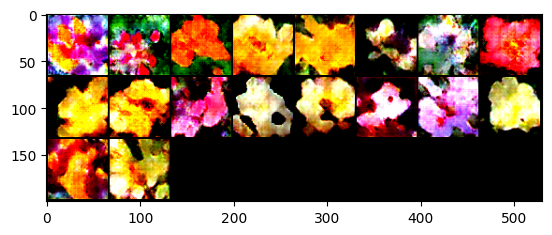

100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


epoch: 5, lossD:0.13500498488400747, lossG:11.30079911056074,lossG_fake:6.045470853453701, lossG_real:5.255328222385888 ,equality:0.7901426310678135


evaluate:86.05647277832031,kid_mean:0.08536721020936966, kid_std:0.04234803840517998,kid_:(tensor(0.0854), tensor(0.0423))


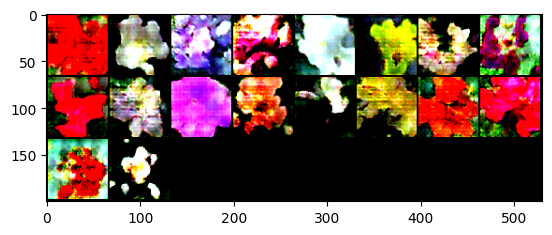

100%|██████████| 103/103 [00:10<00:00,  9.82it/s]


epoch: 6, lossD:0.11189854815963982, lossG:11.778437355189647,lossG_fake:6.176030337231831, lossG_real:5.602407022587304 ,equality:0.5736233146445269


evaluate:86.28343200683594,kid_mean:0.06979086995124817, kid_std:0.03806070238351822,kid_:(tensor(0.0698), tensor(0.0381))


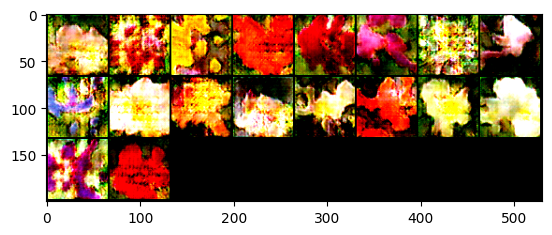

100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


epoch: 7, lossD:0.2667787441423217, lossG:12.019160215137074,lossG_fake:6.349124403833185, lossG_real:5.670035808699803 ,equality:0.6790885951333827


evaluate:87.6023178100586,kid_mean:0.07291214168071747, kid_std:0.03964494168758392,kid_:(tensor(0.0729), tensor(0.0396))


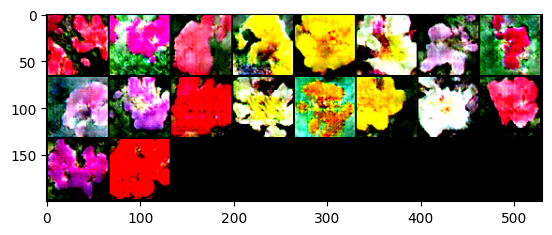

100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


epoch: 8, lossD:0.30061182871605585, lossG:11.963351453392251,lossG_fake:6.343599964114069, lossG_real:5.619751489278182 ,equality:0.7238484748358864


evaluate:88.94721984863281,kid_mean:0.07262290269136429, kid_std:0.04550011828541756,kid_:(tensor(0.0726), tensor(0.0455))


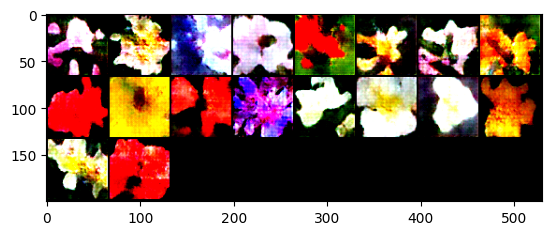

100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


epoch: 9, lossD:0.16883398272386455, lossG:11.009439885037617,lossG_fake:5.759875944517191, lossG_real:5.249563920845106 ,equality:0.5103120236720846


evaluate:89.83341217041016,kid_mean:0.07628089189529419, kid_std:0.044718001037836075,kid_:(tensor(0.0763), tensor(0.0447))


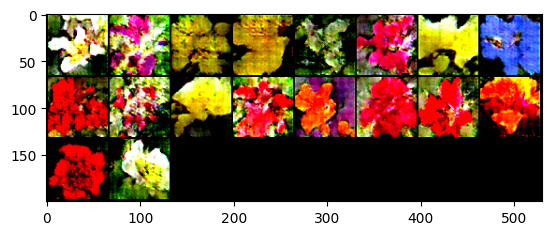

100%|██████████| 103/103 [00:10<00:00, 10.30it/s]


epoch: 10, lossD:0.10902250341130691, lossG:11.096654780860087,lossG_fake:5.757558169874173, lossG_real:5.339096599412196 ,equality:0.41846157046197696


evaluate:88.94965362548828,kid_mean:0.07662726193666458, kid_std:0.04407557100057602,kid_:(tensor(0.0766), tensor(0.0441))


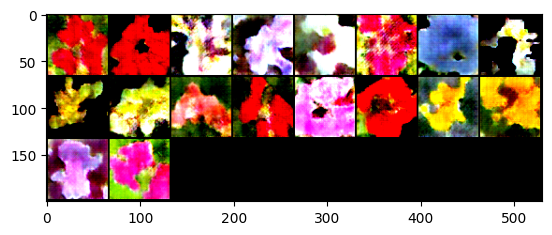

100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


epoch: 11, lossD:0.13406734682113222, lossG:11.453596624355871,lossG_fake:5.964200545861883, lossG_real:5.489396069813701 ,equality:0.474804476048182


evaluate:89.17322540283203,kid_mean:0.09250091761350632, kid_std:0.049531884491443634,kid_:(tensor(0.0925), tensor(0.0495))


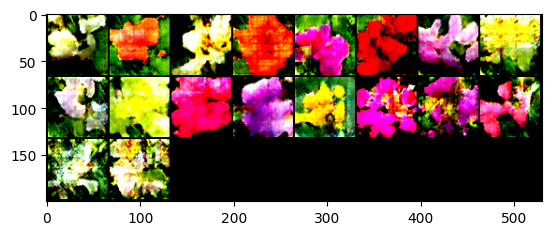

100%|██████████| 103/103 [00:10<00:00, 10.20it/s]


epoch: 12, lossD:0.11712890523440629, lossG:11.86009674627804,lossG_fake:6.191105219924334, lossG_real:5.6689915078357584 ,equality:0.5221137120885757


evaluate:89.76924896240234,kid_mean:0.08549440652132034, kid_std:0.04800157994031906,kid_:(tensor(0.0855), tensor(0.0480))


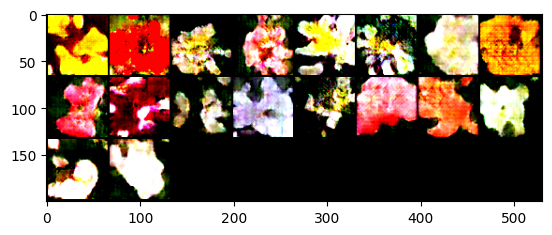

100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


epoch: 13, lossD:0.20827237478665356, lossG:12.280764551996027,lossG_fake:6.506033742312089, lossG_real:5.7747308166281694 ,equality:0.7313029256839192


evaluate:89.0354995727539,kid_mean:0.08368569612503052, kid_std:0.04662815481424332,kid_:(tensor(0.0837), tensor(0.0466))


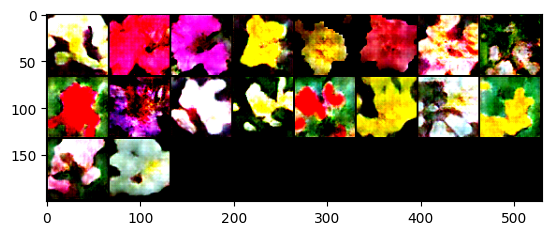

100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


epoch: 14, lossD:0.2038563508223923, lossG:11.743996703508989,lossG_fake:6.313923118834936, lossG_real:5.430073589954562 ,equality:0.8838495288803738


evaluate:89.48969268798828,kid_mean:0.08148400485515594, kid_std:0.04401833191514015,kid_:(tensor(0.0815), tensor(0.0440))


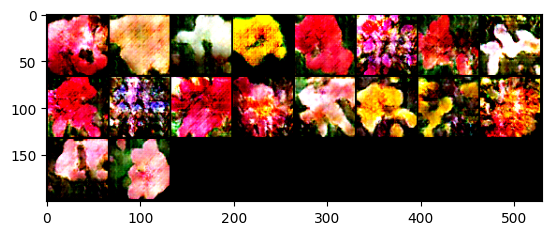

100%|██████████| 103/103 [00:10<00:00, 10.22it/s]


epoch: 15, lossD:0.11324046515561279, lossG:11.734926603372815,lossG_fake:6.088576488124514, lossG_real:5.646350138395736 ,equality:0.44222634972877817


evaluate:88.50297546386719,kid_mean:0.08338263630867004, kid_std:0.04808525741100311,kid_:(tensor(0.0834), tensor(0.0481))


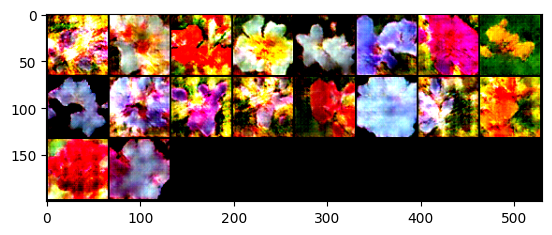

100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


epoch: 16, lossD:0.30283633180107306, lossG:11.798130896484967,lossG_fake:6.189622221062485, lossG_real:5.608508638965273 ,equality:0.5811135820972115


evaluate:87.96923065185547,kid_mean:0.08030083030462265, kid_std:0.04271627962589264,kid_:(tensor(0.0803), tensor(0.0427))


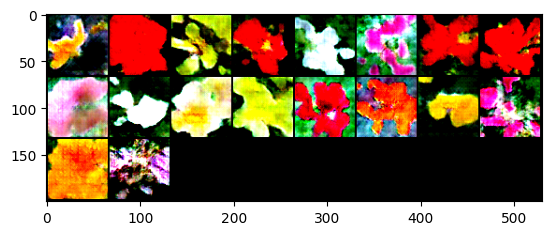

100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


epoch: 17, lossD:0.13815475873721456, lossG:11.718592412263444,lossG_fake:6.036783629250758, lossG_real:5.681808791114289 ,equality:0.354974838136469


evaluate:88.068603515625,kid_mean:0.07740963250398636, kid_std:0.04699897766113281,kid_:(tensor(0.0774), tensor(0.0470))


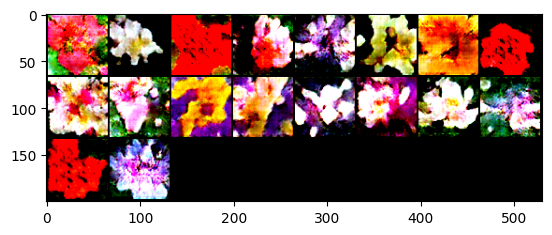

100%|██████████| 103/103 [00:10<00:00, 10.30it/s]


epoch: 18, lossD:0.11041638703826924, lossG:11.989984595659868,lossG_fake:6.310478634047277, lossG_real:5.67950596161259 ,equality:0.6309726724346865


evaluate:87.91621398925781,kid_mean:0.07569649815559387, kid_std:0.041079990565776825,kid_:(tensor(0.0757), tensor(0.0411))


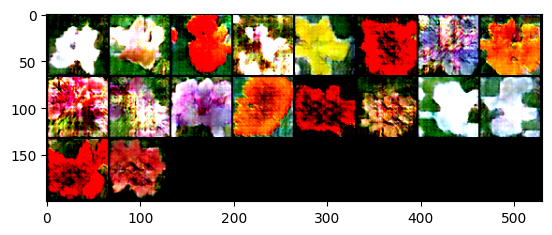

100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


epoch: 19, lossD:0.10080963429244398, lossG:11.76812007126299,lossG_fake:6.078353918871834, lossG_real:5.6897661801680774 ,equality:0.3885877387037562


evaluate:87.44721984863281,kid_mean:0.08151507377624512, kid_std:0.04633183777332306,kid_:(tensor(0.0815), tensor(0.0463))


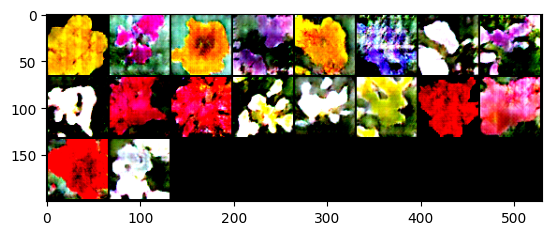

100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


epoch: 20, lossD:0.17522184632139878, lossG:12.201397016210464,lossG_fake:6.375638683986606, lossG_real:5.825758327558202 ,equality:0.549880356428404


evaluate:87.7674331665039,kid_mean:0.08109413832426071, kid_std:0.04679153859615326,kid_:(tensor(0.0811), tensor(0.0468))


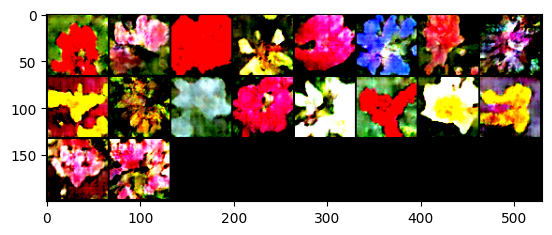

100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


epoch: 21, lossD:0.15510437543531067, lossG:12.18247127532959,lossG_fake:6.315356894604211, lossG_real:5.867114337902625 ,equality:0.44824255670158575


evaluate:88.31314849853516,kid_mean:0.08546922355890274, kid_std:0.04838583245873451,kid_:(tensor(0.0855), tensor(0.0484))


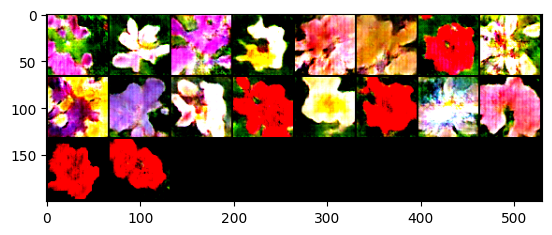

100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


epoch: 22, lossD:0.10791531080398166, lossG:12.404979576184912,lossG_fake:6.653542877400963, lossG_real:5.751436711515038 ,equality:0.9021061658859253


evaluate:88.04576110839844,kid_mean:0.07744386792182922, kid_std:0.04598413407802582,kid_:(tensor(0.0774), tensor(0.0460))


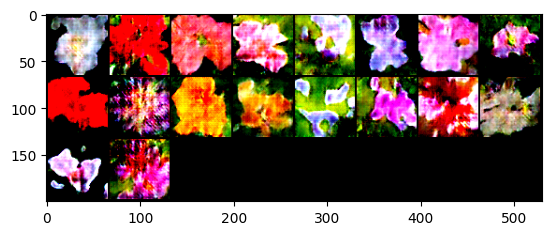

100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


epoch: 23, lossD:0.09126822983176963, lossG:12.050521637629537,lossG_fake:6.452484216504884, lossG_real:5.598037441957344 ,equality:0.8544467745475401


evaluate:87.87747192382812,kid_mean:0.08142473548650742, kid_std:0.04929325357079506,kid_:(tensor(0.0814), tensor(0.0493))


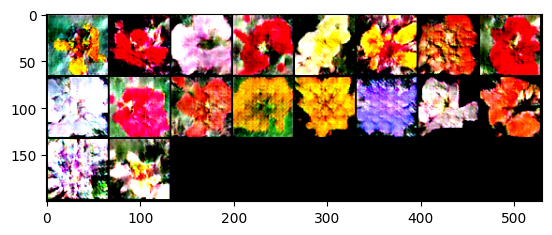

100%|██████████| 103/103 [00:10<00:00, 10.12it/s]


epoch: 24, lossD:0.12101353965337994, lossG:12.725316732832528,lossG_fake:6.765934927949628, lossG_real:5.959381829187708 ,equality:0.8065530987619196


evaluate:87.33000946044922,kid_mean:0.08402129262685776, kid_std:0.04167402163147926,kid_:(tensor(0.0840), tensor(0.0417))


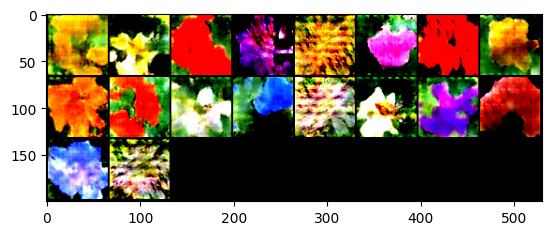

100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


epoch: 25, lossD:0.14083145462989227, lossG:12.578273625049777,lossG_fake:6.649764118264023, lossG_real:5.928509515466042 ,equality:0.7212546027979805


evaluate:86.77967071533203,kid_mean:0.07828734070062637, kid_std:0.0456707738339901,kid_:(tensor(0.0783), tensor(0.0457))


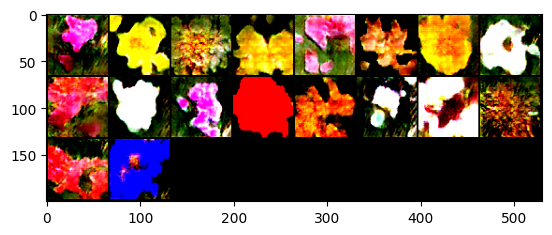

100%|██████████| 103/103 [00:09<00:00, 10.31it/s]


epoch: 26, lossD:0.1914178812785924, lossG:12.938290290462161,lossG_fake:6.821209320165579, lossG_real:6.117080996337446 ,equality:0.7041283238281331


evaluate:84.61398315429688,kid_mean:0.07857826352119446, kid_std:0.04338772967457771,kid_:(tensor(0.0786), tensor(0.0434))


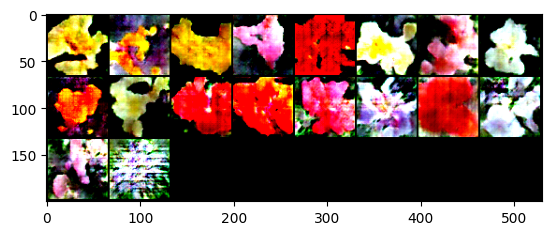

100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


epoch: 27, lossD:0.17443191350519077, lossG:12.53187825841811,lossG_fake:6.588693085226041, lossG_real:5.943185181293673 ,equality:0.6455079039323675


evaluate:84.32069396972656,kid_mean:0.07418791204690933, kid_std:0.043410904705524445,kid_:(tensor(0.0742), tensor(0.0434))


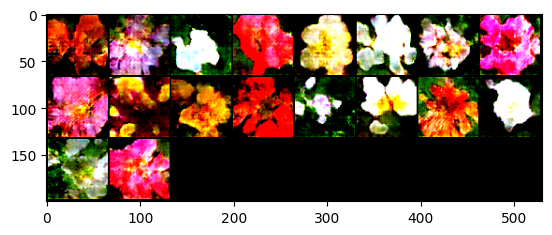

100%|██████████| 103/103 [00:10<00:00, 10.13it/s]


epoch: 28, lossD:0.22098793384157916, lossG:12.165607415356682,lossG_fake:6.387656567166153, lossG_real:5.777950799580917 ,equality:0.6097057675852362


evaluate:84.17411804199219,kid_mean:0.07470899820327759, kid_std:0.047934968024492264,kid_:(tensor(0.0747), tensor(0.0479))


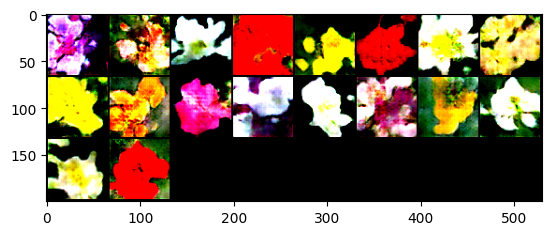

100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


epoch: 29, lossD:0.0974742541342829, lossG:12.086572295253717,lossG_fake:6.292031614525804, lossG_real:5.794540650636247 ,equality:0.4974909638895575


evaluate:83.93560028076172,kid_mean:0.07486401498317719, kid_std:0.042421676218509674,kid_:(tensor(0.0749), tensor(0.0424))


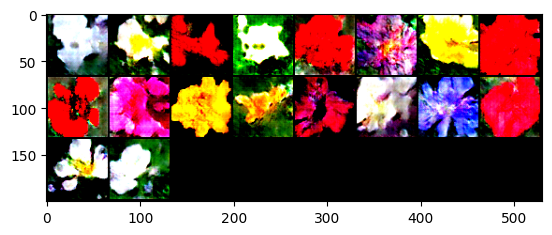

100%|██████████| 103/103 [00:10<00:00, 10.30it/s]


epoch: 30, lossD:0.0954805596469386, lossG:12.23155254993624,lossG_fake:6.32529702695828, lossG_real:5.906255550754881 ,equality:0.4190414762033994


evaluate:84.47550964355469,kid_mean:0.08374281972646713, kid_std:0.04796529561281204,kid_:(tensor(0.0837), tensor(0.0480))


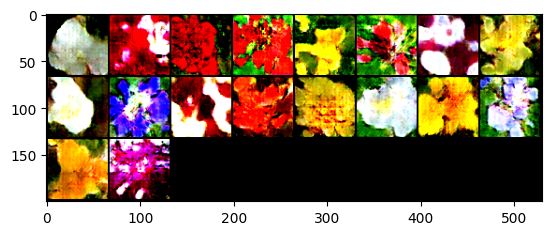

100%|██████████| 103/103 [00:10<00:00, 10.22it/s]


epoch: 31, lossD:0.11427996976717004, lossG:12.434398086325636,lossG_fake:6.55412230908292, lossG_real:5.8802757587247685 ,equality:0.6738465503581512


evaluate:84.11365509033203,kid_mean:0.08077290654182434, kid_std:0.042109329253435135,kid_:(tensor(0.0808), tensor(0.0421))


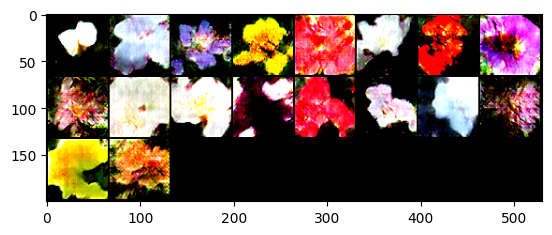

100%|██████████| 103/103 [00:10<00:00, 10.17it/s]


epoch: 32, lossD:0.14974053469893422, lossG:13.061931304561282,lossG_fake:6.7112606752266, lossG_real:6.350670580725068 ,equality:0.3605900945015321


evaluate:84.94840240478516,kid_mean:0.0802663043141365, kid_std:0.042319461703300476,kid_:(tensor(0.0803), tensor(0.0423))


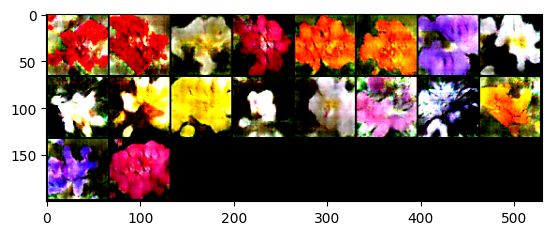

100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


epoch: 33, lossD:0.07904218960083226, lossG:12.863974432343419,lossG_fake:6.692372991043387, lossG_real:6.171601436670544 ,equality:0.5207715543728426


evaluate:84.69293212890625,kid_mean:0.07990578562021255, kid_std:0.040775198489427567,kid_:(tensor(0.0799), tensor(0.0408))


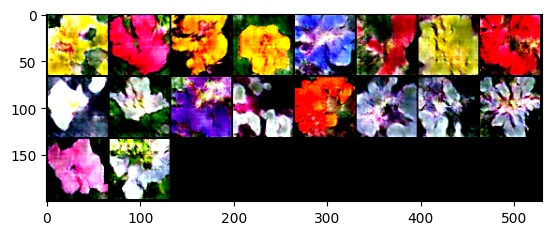

100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


epoch: 34, lossD:0.12098121091506435, lossG:12.823703497358895,lossG_fake:6.713641178260729, lossG_real:6.110062312153937 ,equality:0.6035788661067922


evaluate:84.41715240478516,kid_mean:0.0730537474155426, kid_std:0.043875306844711304,kid_:(tensor(0.0731), tensor(0.0439))


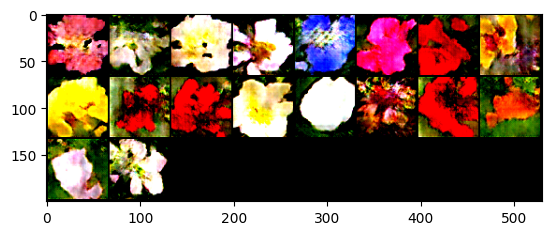

100%|██████████| 103/103 [00:10<00:00, 10.22it/s]


epoch: 35, lossD:0.07009888830983523, lossG:12.842743669898764,lossG_fake:6.831765311435588, lossG_real:6.010978379295867 ,equality:0.820786932139721


evaluate:83.97173309326172,kid_mean:0.08169542253017426, kid_std:0.04573558643460274,kid_:(tensor(0.0817), tensor(0.0457))


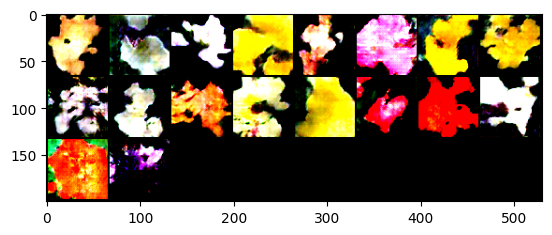

100%|██████████| 103/103 [00:10<00:00, 10.20it/s]


epoch: 36, lossD:0.24750831873309845, lossG:13.457597676990101,lossG_fake:7.028641819085889, lossG_real:6.428955848500567 ,equality:0.5996859705853224


evaluate:84.40631866455078,kid_mean:0.07330869883298874, kid_std:0.04400821030139923,kid_:(tensor(0.0733), tensor(0.0440))


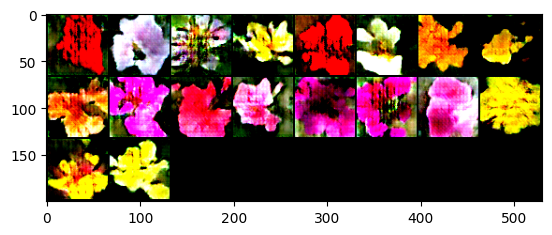

100%|██████████| 103/103 [00:10<00:00, 10.17it/s]


epoch: 37, lossD:0.0735832516610333, lossG:12.776437120530211,lossG_fake:6.585676246476405, lossG_real:6.19076087636855 ,equality:0.3949153701078547


evaluate:83.50918579101562,kid_mean:0.07579739391803741, kid_std:0.05091911926865578,kid_:(tensor(0.0758), tensor(0.0509))


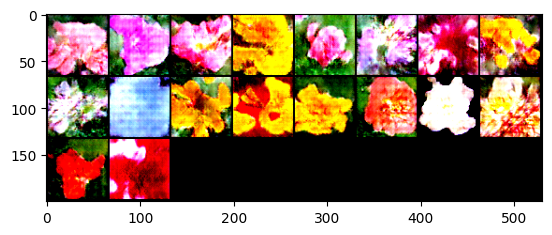

100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


epoch: 38, lossD:0.1102482862589718, lossG:12.782509988951452,lossG_fake:6.496165548713462, lossG_real:6.286344461070681 ,equality:0.20982108764278085


evaluate:82.53472137451172,kid_mean:0.08157913386821747, kid_std:0.04388739541172981,kid_:(tensor(0.0816), tensor(0.0439))


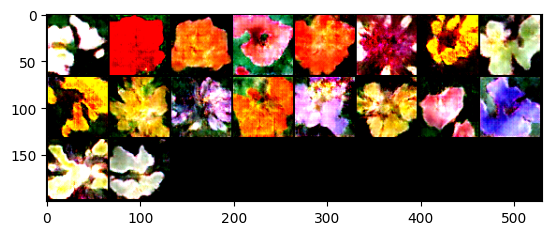

100%|██████████| 103/103 [00:10<00:00, 10.18it/s]


epoch: 39, lossD:0.1110703555812824, lossG:13.014606512865974,lossG_fake:6.913577654986706, lossG_real:6.101028847462922 ,equality:0.8125488075237834


evaluate:81.8228988647461,kid_mean:0.07029131054878235, kid_std:0.04329647123813629,kid_:(tensor(0.0703), tensor(0.0433))


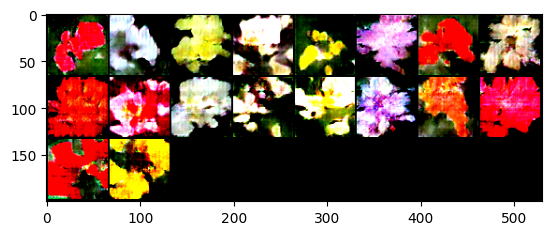

100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


epoch: 40, lossD:0.07311290969113701, lossG:13.087392075547895,lossG_fake:6.833464928043699, lossG_real:6.2539271637074 ,equality:0.5795377643362993


evaluate:81.70996856689453,kid_mean:0.08370181173086166, kid_std:0.044602636247873306,kid_:(tensor(0.0837), tensor(0.0446))


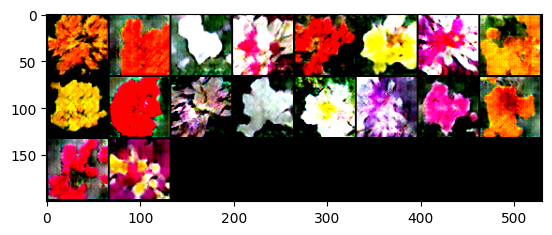

100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


epoch: 41, lossD:0.12013774036059102, lossG:13.045232393209217,lossG_fake:6.747955926413675, lossG_real:6.297276500359322 ,equality:0.45067942605435274


evaluate:82.69573211669922,kid_mean:0.07254555076360703, kid_std:0.04039366543292999,kid_:(tensor(0.0725), tensor(0.0404))


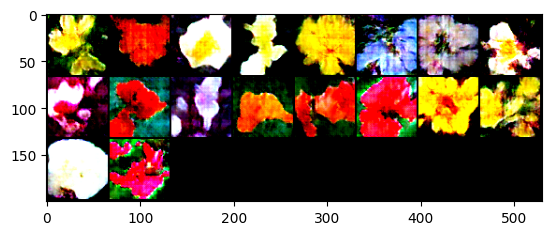

100%|██████████| 103/103 [00:10<00:00, 10.23it/s]


epoch: 42, lossD:0.06431072114885432, lossG:12.702613710199746,lossG_fake:6.500104149568428, lossG_real:6.2025095652608035 ,equality:0.29759458430762464


evaluate:82.68617248535156,kid_mean:0.07163598388433456, kid_std:0.04548006132245064,kid_:(tensor(0.0716), tensor(0.0455))


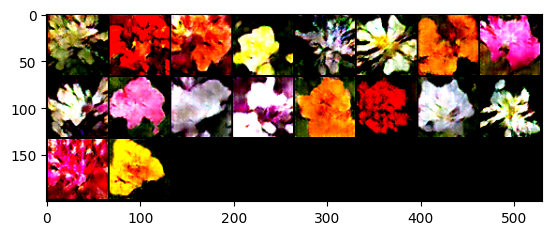

100%|██████████| 103/103 [00:10<00:00, 10.18it/s]


epoch: 43, lossD:0.2874197596232, lossG:13.564415079876056,lossG_fake:7.325014000957452, lossG_real:6.239401023364762 ,equality:1.0856129775926906


evaluate:82.10209655761719,kid_mean:0.07021614164113998, kid_std:0.04418356716632843,kid_:(tensor(0.0702), tensor(0.0442))


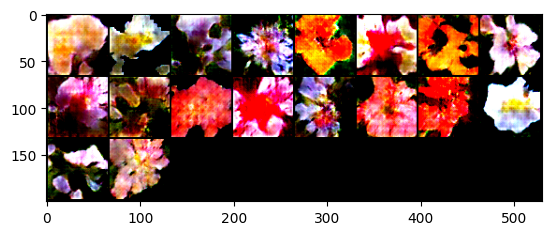

100%|██████████| 103/103 [00:10<00:00, 10.21it/s]


epoch: 44, lossD:0.12707527050549544, lossG:12.600346222664546,lossG_fake:6.62466297566312, lossG_real:5.975683196077069 ,equality:0.6489797795860506


evaluate:80.9280776977539,kid_mean:0.07616912573575974, kid_std:0.04521109163761139,kid_:(tensor(0.0762), tensor(0.0452))


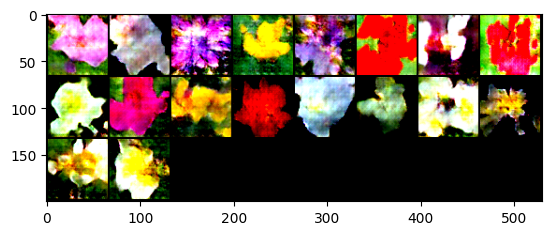

100%|██████████| 103/103 [00:10<00:00,  9.99it/s]


epoch: 45, lossD:0.08466909827610243, lossG:13.649584649835976,lossG_fake:7.520897851406949, lossG_real:6.128686752134157 ,equality:1.3922110992727923


evaluate:80.9964599609375,kid_mean:0.07448301464319229, kid_std:0.047863785177469254,kid_:(tensor(0.0745), tensor(0.0479))


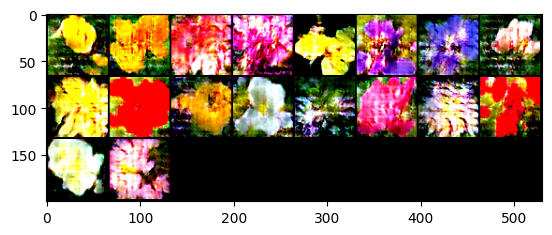

100%|██████████| 103/103 [00:10<00:00, 10.21it/s]


epoch: 46, lossD:0.12157374313010753, lossG:13.129407743805821,lossG_fake:6.891175904320281, lossG_real:6.2382317966627845 ,equality:0.6529441076574969


evaluate:81.05123138427734,kid_mean:0.06916435062885284, kid_std:0.04639563709497452,kid_:(tensor(0.0692), tensor(0.0464))


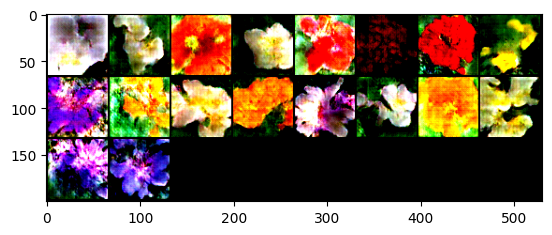

100%|██████████| 103/103 [00:10<00:00, 10.20it/s]


epoch: 47, lossD:0.12195272235543404, lossG:13.020178257840351,lossG_fake:6.797018090208757, lossG_real:6.223160144194816 ,equality:0.5738579460139412


evaluate:80.73143005371094,kid_mean:0.07966488599777222, kid_std:0.05443378537893295,kid_:(tensor(0.0797), tensor(0.0544))


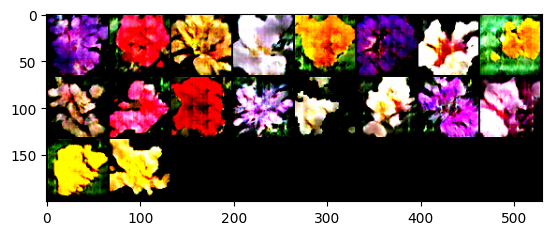

100%|██████████| 103/103 [00:10<00:00, 10.20it/s]


epoch: 48, lossD:0.10072327830186746, lossG:12.907401566366547,lossG_fake:6.5930808771003795, lossG_real:6.314320710098859 ,equality:0.2787601670015203


evaluate:80.88883209228516,kid_mean:0.07038296014070511, kid_std:0.03977223485708237,kid_:(tensor(0.0704), tensor(0.0398))


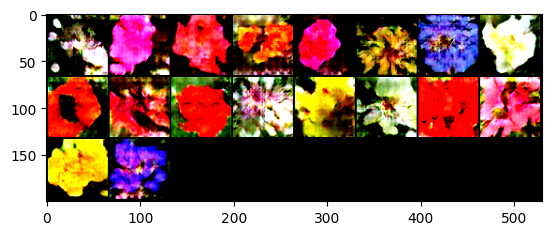

100%|██████████| 103/103 [00:10<00:00, 10.16it/s]


epoch: 49, lossD:0.15156794341226804, lossG:13.68068070087618,lossG_fake:7.138009000750421, lossG_real:6.542671747578001 ,equality:0.5953372531724206


evaluate:80.72362518310547,kid_mean:0.0734153538942337, kid_std:0.044603608548641205,kid_:(tensor(0.0734), tensor(0.0446))


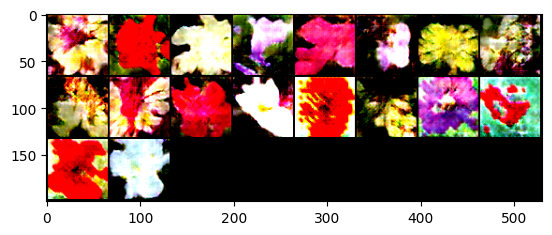

In [93]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))


        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()

        #train generator

        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake


        lossG.backward()
        optimizerG.step()

        # save loss

        running_lossD += lossD.item()
        running_lossG += lossG.item()

        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()



    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()



    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

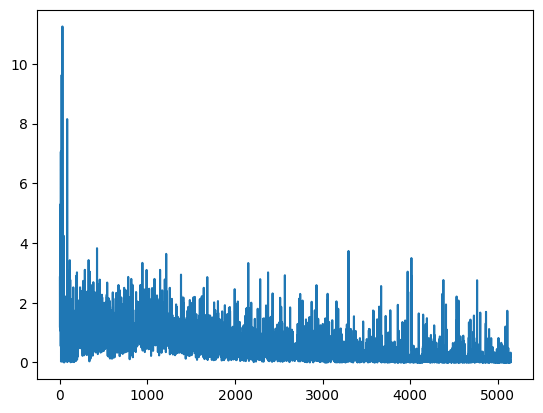

In [83]:
plt.plot(raw_lossesD)

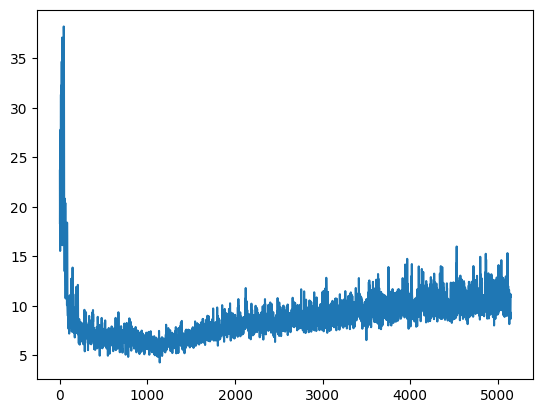

In [84]:
plt.plot(raw_lossesG)

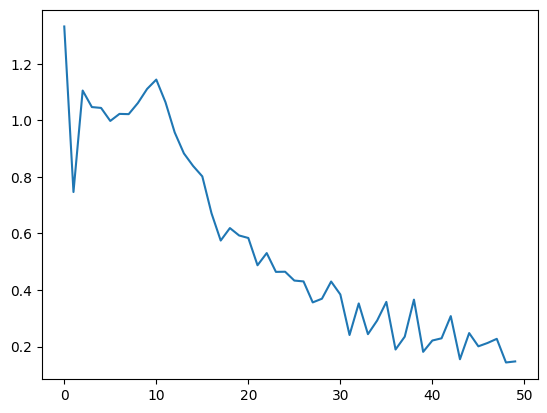

In [85]:
plt.plot(lossesD)

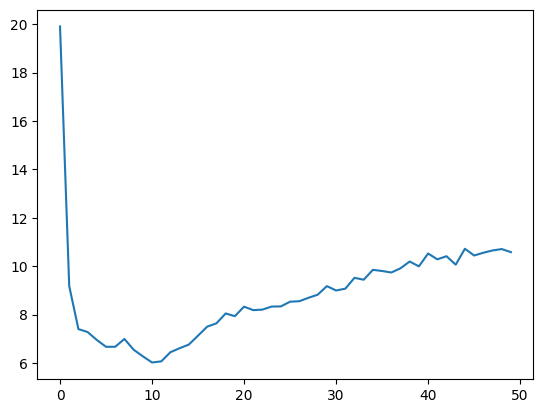

In [86]:
plt.plot(lossesG)

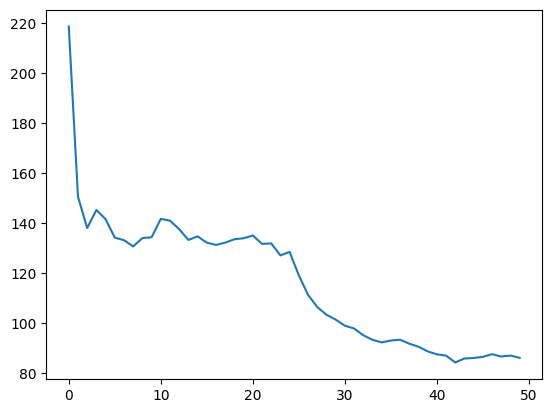

In [87]:
plt.plot(fid_)

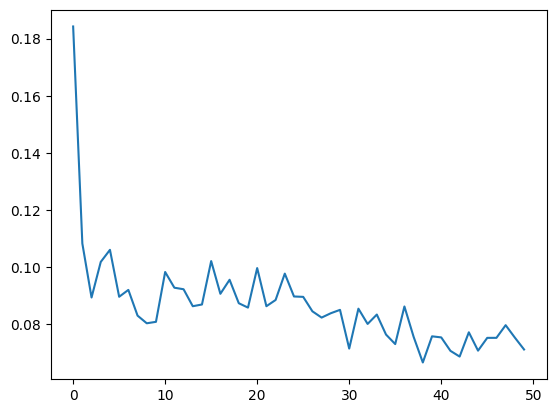

In [88]:
plt.plot(kid_mean_)

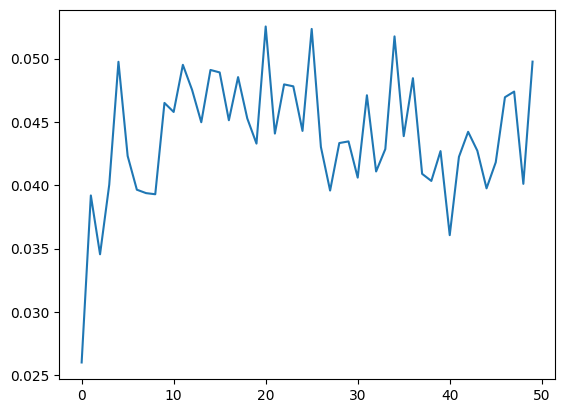

In [89]:
plt.plot(kid_std_)

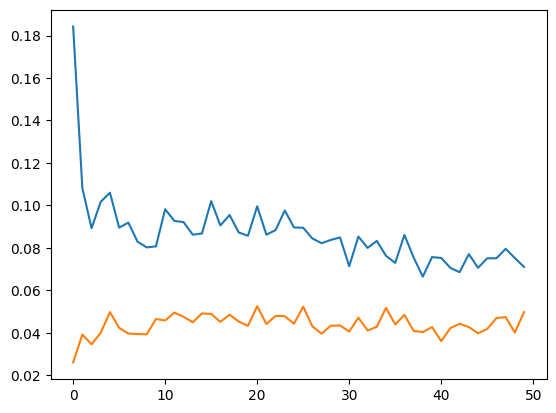

In [90]:
plt.plot(kid_score)

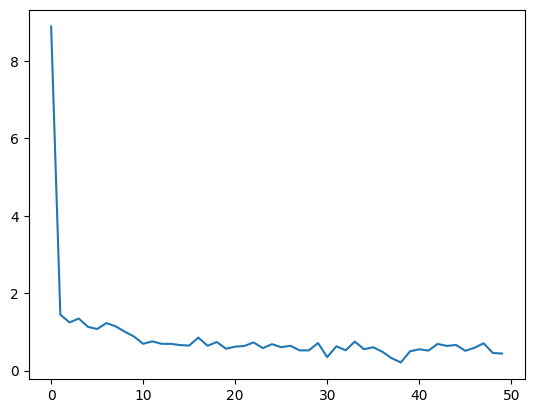

In [91]:
plt.plot(d_equality)

In [92]:

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
fid.compute()

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
kid.compute()

(tensor(0.0681), tensor(0.0367))